In [ ]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! ls

kaggle.json  sample_data


In [ ]:
! ls  ~/.kaggle/

kaggle.json


In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d tommykamaz/faces-dataset-small

100% 3.99G/3.99G [02:59<00:00, 22.3MB/s]
100% 3.99G/3.99G [02:59<00:00, 23.9MB/s]


In [ ]:
!nvidia-smi

Tue Jan  3 16:57:36 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P0    27W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!mkdir data
!unzip -q -o faces-dataset-small.zip -d data  

В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [ ]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch.optim as optim
from sklearn.model_selection import LeaveOneOut, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
import plotly.express as px

%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

## Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://drive.google.com/file/d/1KWPc4Pa7u2TWekUvNu9rTSO0U2eOlZA9/view?usp=sharing)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [ ]:
DATA_DIR = './data/'

In [ ]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
def get_dataloader(image_size, batch_size, device):
    """
    Builds dataloader for training data.
    Use tt.Compose and tt.Resize for transformations
    :param image_size: height and wdith of the image
    :param batch_size: batch_size of the dataloader
    :returns: DataLoader object 
    """

    train_ds = ImageFolder(DATA_DIR, transform=tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

    train_dl = DataLoader(train_ds, batch_size, shuffle=True, pin_memory=True)
    return train_ds, DeviceDataLoader(train_dl, device)
     

In [ ]:
image_size = 128
batch_size = 64

train_dataset, dataloader = get_dataloader(image_size, batch_size, device)

## Часть 2. Построение и обучение модели (2 балла)

In [ ]:
discriminator = nn.Sequential(
    # in: 3 x 128 x 128

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 64 x 64

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 32 x 32

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 16 x 16

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 8 x 8

    
    nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(1024),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 1024 x 4 x 4

    nn.Conv2d(1024, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [ ]:
latent_size = 256

In [ ]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 1024, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(1024),
    nn.ReLU(True),
    # out: 1024 x 4 x 4

    nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 8 x 8

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 16 x 16

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 32 x 32

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 64 x 64

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 128 x 128
)

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

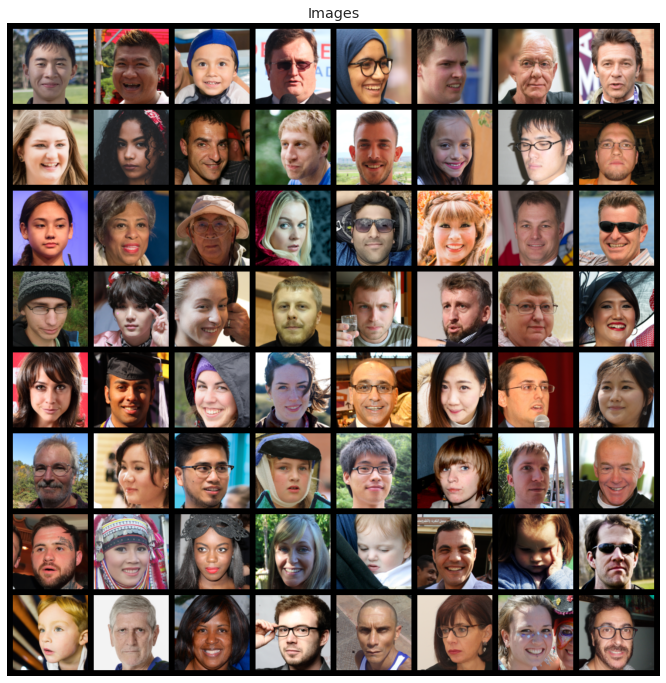

In [ ]:
batch = next(iter(dataloader))
plt.figure(figsize=(12, 12))
plt.axis("off")
plt.title("Images")
plt.imshow(np.transpose(make_grid(batch[0][:64], padding=10, normalize=True).cpu(), (1, 2, 0)));

In [ ]:
def fit(dataloader, model, criterion,optimzer, epochs, lr, start_idx=1):
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images, _ in tqdm(dataloader):
            # Train discriminator
            # Clear discriminator gradients
            optimizer["discriminator"].zero_grad()

            # Pass real images through discriminator
            real_preds = model["discriminator"](real_images)
            real_targets = torch.ones(real_images.size(0), 1, device=device)
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # Pass fake images through discriminator
            fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # Update discriminator weights
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())


            # Train generator
            # Clear generator gradients
            optimizer["generator"].zero_grad()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)
            
            # Try to fool the discriminator
            preds = model["discriminator"](fake_images)
            targets = torch.ones(batch_size, 1, device=device)
            loss_g = criterion["generator"](preds, targets)
            
            # Update generator weights
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())
            
        # Record losses & scores
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, 
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))
    
    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
lr = 0.0002
epochs = 35

model = {
    "discriminator": to_device(discriminator, device),
    "generator": to_device(generator, device)
}

optimizer = {
    "discriminator": optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999)),
    "generator": optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}

losses_g, losses_d, real_scores, fake_scores = fit(dataloader, model, criterion, optimizer, epochs, lr)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/35], loss_g: 8.6049, loss_d: 0.2614, real_score: 0.9405, fake_score: 0.0588


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [2/35], loss_g: 8.0442, loss_d: 0.4333, real_score: 0.8924, fake_score: 0.0970


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [3/35], loss_g: 8.2172, loss_d: 0.2190, real_score: 0.9302, fake_score: 0.0782


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [4/35], loss_g: 8.9125, loss_d: 0.2386, real_score: 0.9272, fake_score: 0.0736


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [5/35], loss_g: 8.7083, loss_d: 0.2834, real_score: 0.9099, fake_score: 0.0808


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [6/35], loss_g: 8.5312, loss_d: 0.5077, real_score: 0.8835, fake_score: 0.1134


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [7/35], loss_g: 8.0871, loss_d: 0.4322, real_score: 0.8863, fake_score: 0.1121


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [8/35], loss_g: 7.3955, loss_d: 0.3366, real_score: 0.9026, fake_score: 0.1080


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [9/35], loss_g: 7.0873, loss_d: 0.2678, real_score: 0.9218, fake_score: 0.0788


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [10/35], loss_g: 6.5429, loss_d: 0.1720, real_score: 0.9370, fake_score: 0.0536


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [11/35], loss_g: 7.2859, loss_d: 0.3085, real_score: 0.9164, fake_score: 0.0766


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [12/35], loss_g: 7.2928, loss_d: 0.3143, real_score: 0.9239, fake_score: 0.0758


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [13/35], loss_g: 6.9848, loss_d: 0.3787, real_score: 0.9085, fake_score: 0.0946


  0%|          | 0/50 [00:00<?, ?it/s]

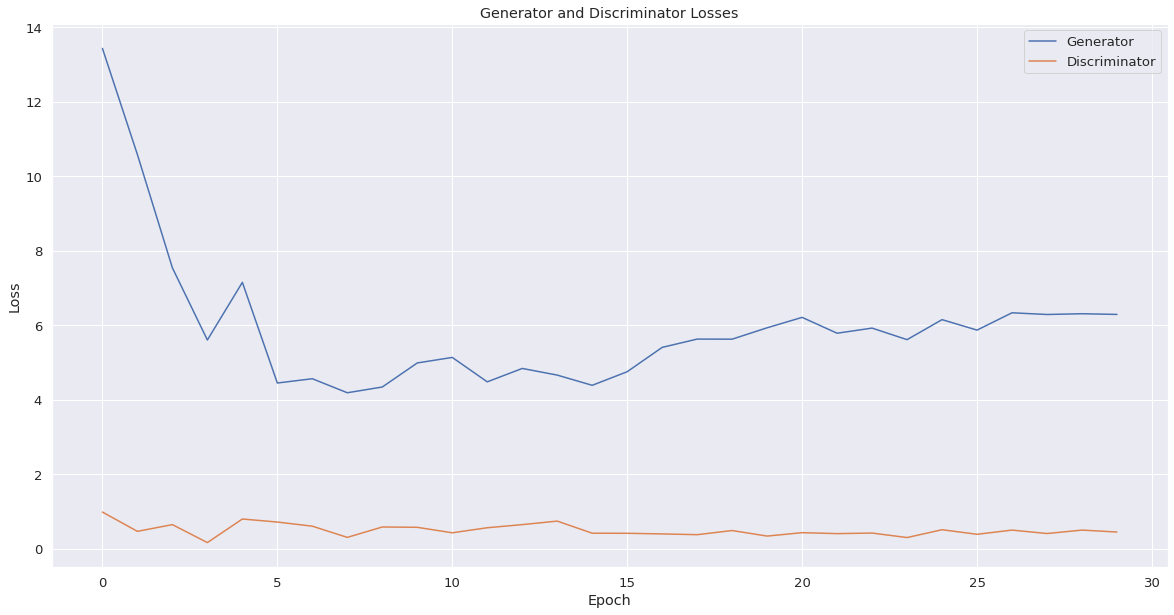

In [ ]:
plt.figure(figsize=(20, 10))
plt.title("Generator and Discriminator Losses")
plt.plot(losses_g, label="Generator")
plt.plot(losses_d, label="Discriminator")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

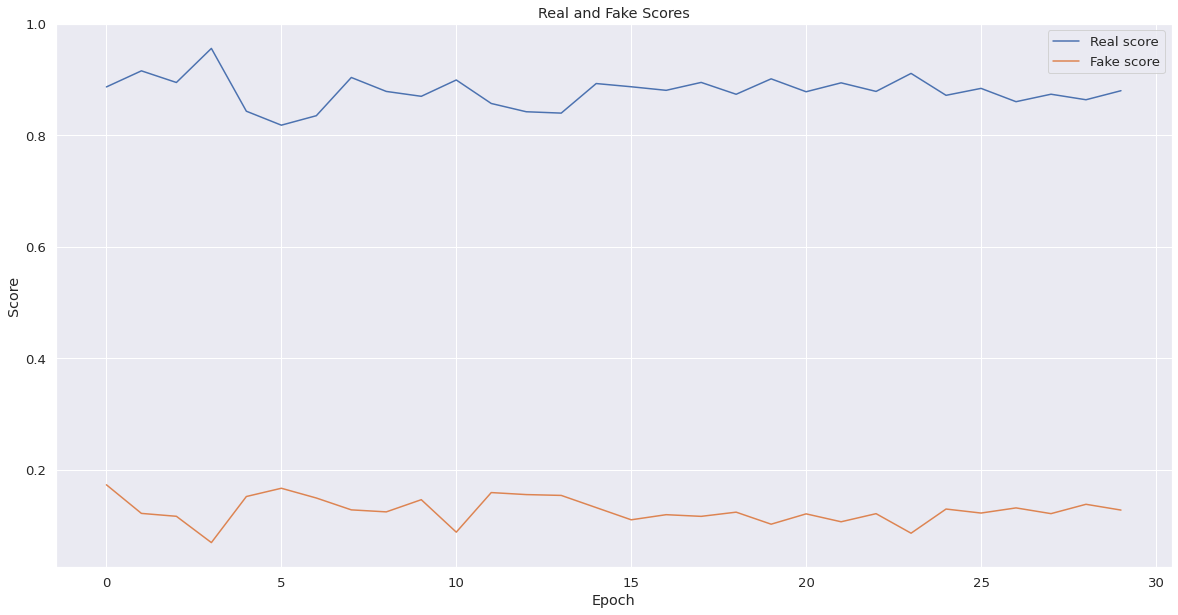

In [ ]:
plt.figure(figsize=(20, 10))
plt.title("Real and Fake Scores")
plt.plot(real_scores, label="Real score")
plt.plot(fake_scores, label="Fake score")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.show()

Характер зависимости имеет тот же вид, что и в рассмотренных примерах на лекции и семинаре. Лосс генератора сначала падает, затем начинает расти и выходит на плато

## Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

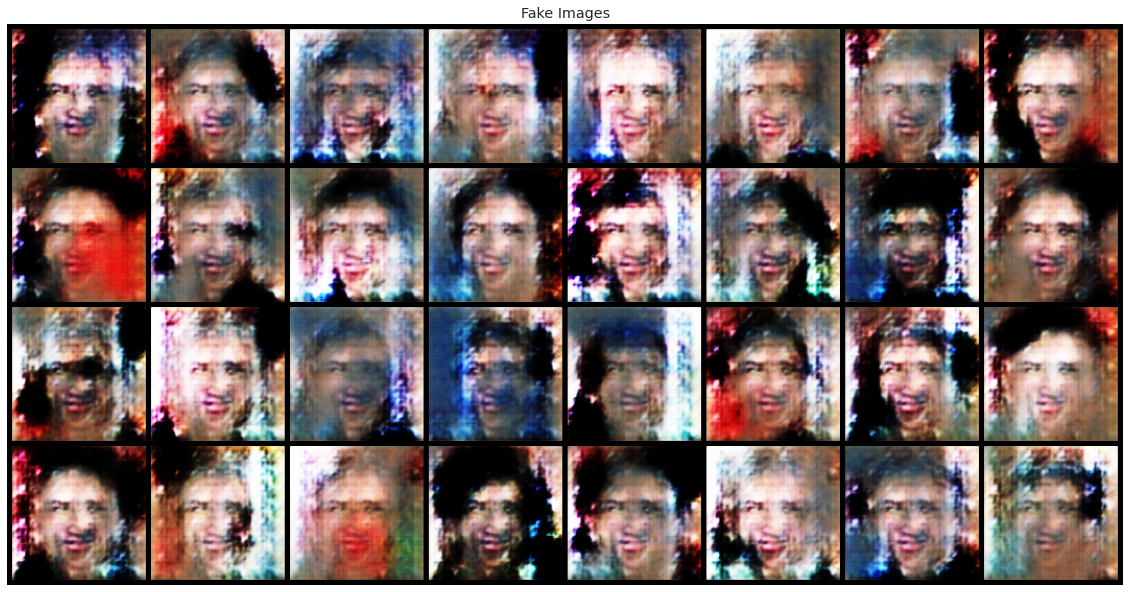

In [ ]:
n_images = 32

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
model["generator"].eval()
with torch.no_grad():
    fake_images = model["generator"](fixed_latent).cpu()
     

def show_images(generated):
    plt.figure(figsize=(20, 20))
    plt.axis("off")
    plt.title("Fake Images")
    plt.imshow(np.transpose(make_grid(fake_images, padding=5, normalize=True),(1, 2, 0)))
     

show_images(fake_images)

В данном случае обучал на 30 эпохах, и качество не очень, когда обучал на 45 было вполне неплохое

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [ ]:
max_images = 300
     

fixed_latent = torch.randn(max_images, latent_size, 1, 1, device=device)

model["generator"].eval()
with torch.no_grad():
    fake_images = model["generator"](fixed_latent).cpu()
     

real_images = []
for idx in tqdm(range(max_images)):
    real_images.append(train_dataset[idx][0])
     



  0%|          | 0/300 [00:00<?, ?it/s]

In [ ]:
real_images[0].shape

torch.Size([3, 128, 128])

In [ ]:
fake_images.shape

torch.Size([300, 3, 128, 128])

In [ ]:
fake_images_reshape = fake_images.reshape(fake_images.shape[0], -1)
real_images_reshape = torch.stack(real_images).reshape(fake_images.shape[0], -1)
     

X = torch.concat([fake_images_reshape, real_images_reshape]).numpy()
y = torch.concat((torch.ones(max_images), torch.zeros(max_images))).numpy()


In [ ]:
%%time
cv_scores = cross_val_score(KNeighborsClassifier(n_neighbors=1), X, y, cv=LeaveOneOut())
print(f"LOO score: {cv_scores.mean()}")

LOO score: 0.9366666666666666
CPU times: user 2min 1s, sys: 1min 35s, total: 3min 36s
Wall time: 1min 53s


In [ ]:
reducer = TSNE(n_components=2)
X_reduced = reducer.fit_transform(X)

fig = px.scatter(X_reduced, x=0, y=1, color=y.astype(str), labels={'0': 'first-tsne-feature', '1': 'second-tsne-feature'})
fig.show()

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
